## Experiment Setup

###  Random seed / Colab / CUDA related

In [1]:
import time
import datetime
import importlib
import os

# Use Google Colab
use_colab = True

# Is this running on Colab?
colab_available = importlib.util.find_spec("google.colab") is not None

if use_colab and colab_available:
    # Mount my Google Drive root folder
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Pyro
    !pip install pyro-ppl

    # cd to bayesian-dl-experiments directory
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    !ls

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
random_seed = 682

### Third party libraries (NumPy, PyTorch, Pyro)

In [ ]:
# Third party libraries import
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt

# Print version information
print("NumPy Version: " + np.__version__)
print("PyTorch Version: " + torch.__version__)
print("Pyro Version: " + pyro.__version__)

In [2]:
# More imports...
from torch.utils.data import random_split, DataLoader
from ronald_bdl import datasets, models
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, NUTS, MCMC

# pyplot setting
%matplotlib inline

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')
    torch.backends.cudnn.deterministic = True
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory = True # Faster Host to GPU copies with page-locked memory
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False

### Variable settings

In [3]:
"""
Toy dataset generation based on the experiment from 
the Probabilstic Backpropagation paper (Hernandez-Lobato & Adams, 2015)
"""
# Random seed for toy dataset
dataset_toy_random_seed = 691

# Toy dataset size
dataset_toy_size = 20

# Toy dataset x distribution (uniform) parameters
dataset_toy_x_low = -4
dataset_toy_x_high = 4

# Toy dataset y distribution (normal with noise)
dataset_toy_y_mean = 0
dataset_toy_y_std = 9

In [4]:
"""
MC Dropout related
"""
# Dropout rate
dropout_rate = 0.5

# L2 regularization strength
reg_strength = 0.3

# Epochs
n_epochs = 4000

# Optimizer learning rate
learning_rate = 0.1

# Loss function type
loss_function_type = 'mse_loss'

# Number of test predictions (for each data point)
n_predictions = 10000

In [5]:
# Test start time
test_start_time = datetime.datetime.today().strftime('%Y%m%d%H%M')

# Directory to store the results for this experiment
test_results_path = os.path.join(
    './test_results',
    'comparison_toy',
    (
        test_start_time 
        + '_' + str(n_epochs) 
        + '_' + str(dropout_rate) 
        + '_' + str(reg_strength) 
        + '_' + str(loss_function_type) 
        + '_' + str(n_predictions))
)

# Create the directory if it doesn't exist
os.makedirs(test_results_path)

## Prepare data

### Get the data as a torch Dataset object

In [6]:
dataset = datasets.ToyDatasets(
    random_seed=dataset_toy_random_seed,
    n_samples=dataset_toy_size,
    x_low=dataset_toy_x_low,
    x_high=dataset_toy_x_high,
    y_mean=dataset_toy_y_mean,
    y_std=dataset_toy_y_std,
)

# Get the test data
X_test = torch.linspace(dataset_toy_x_low, dataset_toy_x_high, 100).reshape(100, 1)

# Print the size of the dataset
print("dataset size = " + str((len(dataset), dataset.n_features)))

dataset size = (20, 1)


## Define network

In [7]:
uncertainty_methods = {}

# MC (Bernoulli) dropout
uncertainty_methods['mc_dropout'] = models.FCNetMCDropout(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
    dropout_rate=dropout_rate,
    dropout_type='bernoulli',
)

# Vanilla Variational Inference
uncertainty_methods['variational_inference'] = models.FCNetPyro(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
)

# HMC (NUTS)
uncertainty_methods['hmc'] = models.FCNetPyro(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
)

## Train the network

### Train/test the model

In [8]:
for key, network in uncertainty_methods.items():
    # Reset the random number generator for each method (to produce identical results)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    pyro.set_rng_seed(random_seed)
    
    # Print the method name
    print("Now running " + str(key))
    
    # Send the whole model to the selected torch.device
    network.to(torch_device)

    # Print the network structure
    print(network)
    print()

    train_loader = DataLoader(dataset, batch_size=len(dataset))
    
    # Optimizer setup
    if isinstance(network, models.FCNetMCDropout):
        # Adam optimizer
        # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
        # NOTE: Need to set L2 regularization from here
        optimizer = torch.optim.Adam(
            network.parameters(),
            lr=learning_rate,
            weight_decay=reg_strength, # L2 regularization
        )

        # Mean Squared Error for loss function to minimize
        objective = torch.nn.MSELoss()

    elif isinstance(network, models.FCNetPyro):
        if key == 'variational_inference':
            optimizer = pyro.optim.Adam({"lr": learning_rate})
            svi = SVI(network.model, network.guide, optimizer, loss=Trace_ELBO(), num_samples=1000)
        elif key == 'hmc':
            nuts_kernel = NUTS(network.model)
            mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=1000)
            
        pyro.clear_param_store()
    
    """
    Training
    """

    # Model to train mode
    network.train()

    # Record training start time (for this method)
    tic = time.time()
    
    if key == 'hmc':
        dataset.data_x.to(torch_device)
        dataset.data_y.to(torch_device)
        mcmc.run(dataset.data_x, dataset.data_y)
    else:
        for epoch in range(n_epochs): # loop over the dataset multiple times

            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, targets = data

                # Store the batch to torch_device's memory
                inputs = inputs.to(torch_device)
                targets = targets.to(torch_device)

                if isinstance(network, models.FCNetMCDropout):
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimize
                    outputs = network(inputs)

                    if loss_function_type in ('test_ll_mc', 'rmse_mc'):
                        _, _, _, metrics = network.predict_dist(
                            inputs, n_predictions, y_test=targets, reg_strength=reg_strength)

                        if loss_function_type == 'test_ll_mc':
                            total_loss = -(metrics[loss_function_type])
                    else:
                        total_loss = objective(outputs, targets)

                    total_loss.backward()

                    optimizer.step()

                elif isinstance(network, models.FCNetPyro):
                    pyro.clear_param_store()
                    # calculate the loss and take a gradient step
                    total_loss = svi.step(inputs, targets)

            if epoch % 100 == 0:
                print("[iteration %04d] loss: %.4f" % (epoch + 1, total_loss))
            
    # Record training end time
    toc = time.time()

    # Report the final loss
    print("final loss = " + str(total_loss))            

    # Report the total training time
    print("training time = " + str(toc - tic) + " seconds")
    
    print()

Now running mc_dropout
FCNetMCDropout(
  (input): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Dropout(p=0.5, inplace=False)
  )
  (output): Linear(in_features=100, out_features=1, bias=True)
)

[iteration 0001] loss: 587.7241
[iteration 0101] loss: 70.6787
[iteration 0201] loss: 127.0124
[iteration 0301] loss: 83.2737
[iteration 0401] loss: 104.1114
[iteration 0501] loss: 106.1808
[iteration 0601] loss: 116.4965
[iteration 0701] loss: 107.0075
[iteration 0801] loss: 134.4235
[iteration 0901] loss: 205.4206
[iteration 1001] loss: 116.9937
[iteration 1101] loss: 108.9314
[iteration 1201] loss: 119.3537
[iteration 1301] loss: 147.7226
[iteration 1401] loss: 77.1215
[iteration 1501] loss: 113.6606
[iteration 1601] loss: 90.0757
[iteration 1701] loss: 113.6237
[iteration 1801] loss: 108.2372
[iteration 1901] loss: 139.8246
[iteration 2001] loss: 92.4776
[iteration 2101] loss: 211.8903
[iteration 2201] loss: 94.5155
[iteration 2301] loss: 175.9412
[iterat

testing time = 4.491464853286743 seconds

Mean = tensor([-40.1961, -38.9055, -37.6507, -36.4592, -35.2158, -34.1189, -32.9625,
        -31.7244, -30.4190, -29.2717, -28.1129, -26.8440, -25.6490, -24.3359,
        -23.2146, -21.9402, -20.7683, -19.5466, -18.4102, -17.2379, -15.9537,
        -14.8442, -13.6538, -12.4792, -11.4024, -10.1988,  -9.0505,  -8.0045,
         -6.9571,  -6.0459,  -5.2078,  -4.5066,  -3.8109,  -3.1739,  -2.5448,
         -1.9523,  -1.3208,  -0.7491,  -0.2384,   0.1653,   0.4929,   0.8253,
          1.0443,   1.1859,   1.3233,   1.4308,   1.5222,   1.6260,   1.7630,
          1.8811,   1.9859,   2.0946,   2.2062,   2.3018,   2.4077,   2.4938,
          2.6105,   2.7131,   2.8134,   2.9205,   3.0115,   3.1223,   3.3002,
          3.4854,   3.6613,   3.8345,   4.0357,   4.2437,   4.4373,   4.6832,
          5.0617,   5.5895,   6.3610,   7.1979,   8.1596,   9.2418,  10.2179,
         11.2538,  12.2668,  13.5019,  14.9884,  16.4152,  17.6876,  19.2452,
         20.702

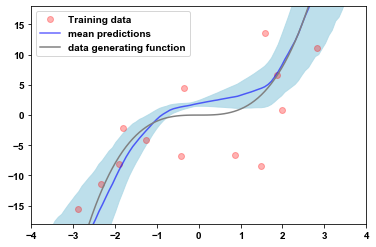

In [15]:
for key, network in uncertainty_methods.items():

    """
    Testing
    """

    # Model to eval mode
    network.eval()
    
    #prediction_non_mc = network(X_test)

    # Record testing start time (for this split)
    tic_testing = time.time()    
    
    predictions, mean, var, metrics = network.predict_dist(X_test, n_predictions)
    
    # Record testing end time
    toc_testing = time.time()
    
    # Report the total testing time
    print("testing time = " + str(toc_testing - tic_testing) + " seconds")
    
    """
    Print results
    """

    print()
    print("Mean = " + str(mean.flatten()))
    print("Variance = " + str(var.flatten()))
    
    # store additional metrics
    if len(metrics) > 0:
        for key, value in metrics.items():
            print(str(key) + " = " + str(value))
        print()
             
    # Plot the uncertainty measured by each methods
    plt.figure()
    
    # Fix the scales of x-axis and y-axis
    plt.xlim(dataset_toy_x_low, dataset_toy_x_high)
    plt.ylim(dataset_toy_y_mean-2*dataset_toy_y_std, dataset_toy_y_mean+2*dataset_toy_y_std)

    # Distributions around the predictions
    plt.fill_between(
        X_test.flatten(), 
        (mean.detach().numpy() - 2*torch.sqrt(var).detach().numpy()).flatten(),
        (mean.detach().numpy() + 2*torch.sqrt(var).detach().numpy()).flatten(),
        color='lightblue', alpha=0.8)

    # Train data
    plt.plot(dataset.data_x, dataset.data_y, 'or', label='Training data', alpha=0.3)

    # MC prediction
    plt.plot(X_test, mean.detach().numpy(), 'blue', label='mean predictions', alpha=0.6)
    
    # Non-MC prediction
    #plt.plot(X_test, prediction_non_mc.detach().numpy(), 'green', label='non-MC prediction', alpha=0.4)
    
    # Original data generating function without noise
    plt.plot(X_test, X_test ** 3, 'gray', label='data generating function')    
    
    plt.legend()
    
    plt.savefig(os.path.join(test_results_path, str(key) + '.png'))
    
    plt.show()